In [1]:
# Importo librerías:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re, requests, nltk, string
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from PIL import Image

In [2]:
# Web principal:
url = "https://www.themoscowtimes.com/"

# Extraemos la info de cada apartado en la web, empezando por News:

# News:
response = requests.get(url+"news")
soup = BeautifulSoup(response.text, "html.parser")
titles_container = soup.findAll('h3', {'class': 'article-excerpt-default__headline'})

titles_info = [title.text for title in titles_container]

In [3]:
# News+Opinion:
response = requests.get(url+"opinion")
titles_info = str(titles_info) + str([title.text for title in titles_container])

In [4]:
# News+Opinion+Business:
response = requests.get(url+"business")
titles_info = str(titles_info) + str([title.text for title in titles_container])

In [5]:
# News+Opinion+Business+ArtAndLife:
response = requests.get(url+"arts-and-life")
titles_info = str(titles_info) + str([title.text for title in titles_container])

In [6]:
# News+Opinion+Business+ArtAndLife+Meanwhile:
response = requests.get(url+"meanwhile")
titles_info = str(titles_info) + str([title.text for title in titles_container])

In [7]:
# Limpiamos signos de puntuación:
def replace_punctuation (text, replace):
      return re.sub("[%s]" % re.escape(string.punctuation), replace, text)

titles_info = replace_punctuation(str(titles_info), "")

In [8]:
# Limpiamos otros caracteres:
titles_info = titles_info.replace("’", "").replace("‘", "").replace("'", "").replace("\n","").replace(
    "\t","").replace("\\ ", "").replace("–", "")

In [9]:
# Todo a minúscula:
titles_info = titles_info.lower()

In [10]:
# Visualizamos resultado:
print(titles_info)

russia detains 87 north korean fishermen vessels for poaching russia test launches new intercontinental ballistic missile  video russia invites climate activist greta thunberg to speak in parliament st petersburg authorities paid local athletes to beat and threaten election observers  meduza russian nuclear engineer fined for mining bitcoin at topsecret lab us sanctions 2 russians connected to kremlin troll factory russian veterans hospital bans transgender hairstylist from charity project russia plans reusable rocket to compete with elon musk by 2024  rbc trumpputin phone calls can only be disclosed with russian consent kremlin says most russians charged for disrespecting authorities insulted putin  rights group hundreds protest police brutality in far east russia after shamans detention  after saudi attacks russia makes its regional presence felt russian antidoping chief calls for dismissal of state sports officials siberian wildfires are fully extinguished authorities say russia qua

In [11]:
# Limpiamos tokenizando y sacando las stopwords:
# Token list: (listamos palabras)
words = nltk.tokenize.word_tokenize(titles_info)

# Stopwords list: (palabras vacías = artículos, pronombres, preposiciones, etc.)
stopwords = nltk.corpus.stopwords.words("english")

# Token list - stopwords:
words_without_stopwords = list(filter(lambda word: word not in stopwords, words))

In [12]:
# Listado frecuencia de las palabras resultantes:
words_except_stop_dist = nltk.FreqDist(words_without_stopwords)

Top 10 frequencies, excluding stopwords:
---------------------------------------------
         Value  Frequency
0       russia         36
1      russian         25
2  authorities         15
3     russians         10
4      kremlin         10
5        calls         10
6       rights         10
7      detains          5
8           87          5
9        north          5
---------------------------------------------


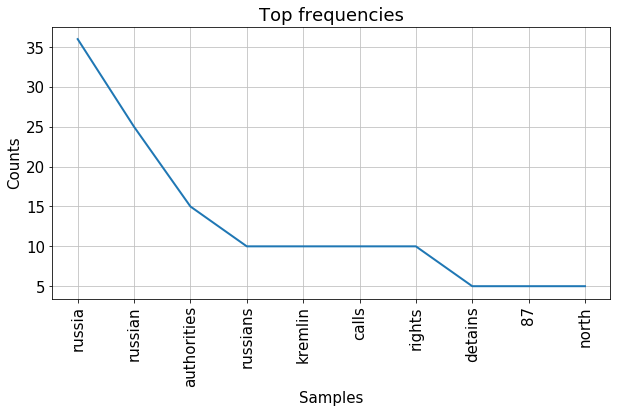

In [13]:
# Resultado en valores y gráfica:
def print_df_and_graph_of_freqdist(top, freqdist):
    #df:
    print("Top", top, "frequencies, excluding stopwords:")
    print("-" * 45)
    print(pd.DataFrame(freqdist.most_common(top), columns = ["Value", "Frequency"]))
    print("-" * 45)
     #graph:   
    plt.figure(figsize=(10,5)) #Change graph size
    plt.rcParams.update({'font.size': 15}) #Change text size
    freqdist.plot(top, title = "Top frequencies")

print_df_and_graph_of_freqdist(10, words_except_stop_dist)

In [14]:
'''Etiquetamos las palabras con idea de deshacernos de aquella clase que no nos aporte info. 
(+info en https://www.sketchengine.eu/penn-treebank-tagset/)'''
word_tags = nltk.pos_tag(words_without_stopwords) # Devuelve una lista
word_tags = pd.DataFrame(word_tags, columns = ["Word", "Tag"]) # Lo pasamos a df

word_tags.head(10)

,Word,Tag
0,russia,NN
1,detains,VBZ
2,87,CD
3,north,JJ
4,korean,JJ
5,fishermen,NNS
6,vessels,NNS
7,poaching,VBG
8,russia,JJ
9,test,NN


In [15]:
# Eliminamos los verbos:
def delete_tag_in_df(df, column, tag): # Starts with! No generic!
    df.drop(df[df[column].str.startswith(tag)].index.tolist(), inplace = True)
    
# Eliminamos valores como "russia", "russian", etc.:
def delete_family_in_df(df, column, family):
    df.drop(df[df[column].str.startswith(family)].index.tolist(), inplace = True)
    
delete_tag_in_df(word_tags, "Tag" , "VB")
delete_tag_in_df(word_tags, "Tag" , "JJ")
delete_tag_in_df(word_tags, "Tag", "CD")
delete_tag_in_df(word_tags, "Word" , "russia")

Top 10 frequencies, excluding stopwords:
---------------------------------------------
         Value  Frequency
0  authorities         15
1      kremlin         10
2       rights         10
3    fishermen          5
4      vessels          5
5         test          5
6      missile          5
7        video          5
8     activist          5
9        greta          5
---------------------------------------------


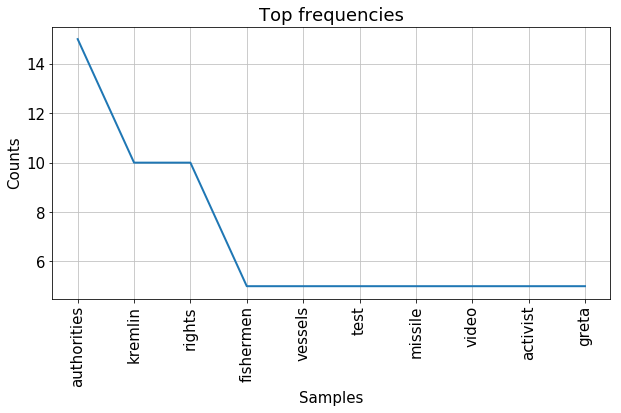

In [16]:
# Listado de frecuencias sin verbos ni familia "russia":
final_words_list = word_tags["Word"].values.tolist()
final_words = nltk.FreqDist(final_words_list)

# Resultado:
print_df_and_graph_of_freqdist(10, final_words)

Top 10 frequencies, excluding stopwords:
---------------------------------------------
           Value  Frequency
0    authorities         15
1  gretathunberg         10
2   stpetersburg         10
3        kremlin         10
4       elonmusk         10
5         rights         10
6      fishermen          5
7        vessels          5
8           test          5
9        missile          5
---------------------------------------------


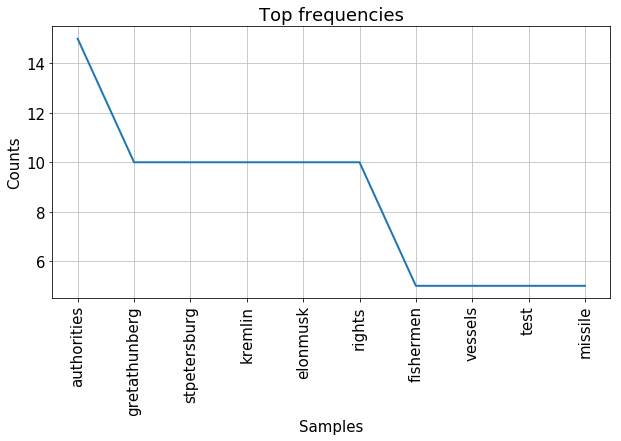

In [17]:
# Revisando la nube de palabras final veo que me ha separado nombres+apellidos y nombres de ciudades, unifico:
word_tags["Word"] = word_tags["Word"].replace({'greta': 'gretathunberg', 'thunberg': 'gretathunberg',
                                               'st': 'stpetersburg', 'petersburg': 'stpetersburg',
                                               'elon': 'elonmusk', 'musk': 'elonmusk'})

# Listado de frecuencias con arreglo del día:
final_words_list = word_tags["Word"].values.tolist()
final_words = nltk.FreqDist(final_words_list)

# Resultado:
print_df_and_graph_of_freqdist(10, final_words)

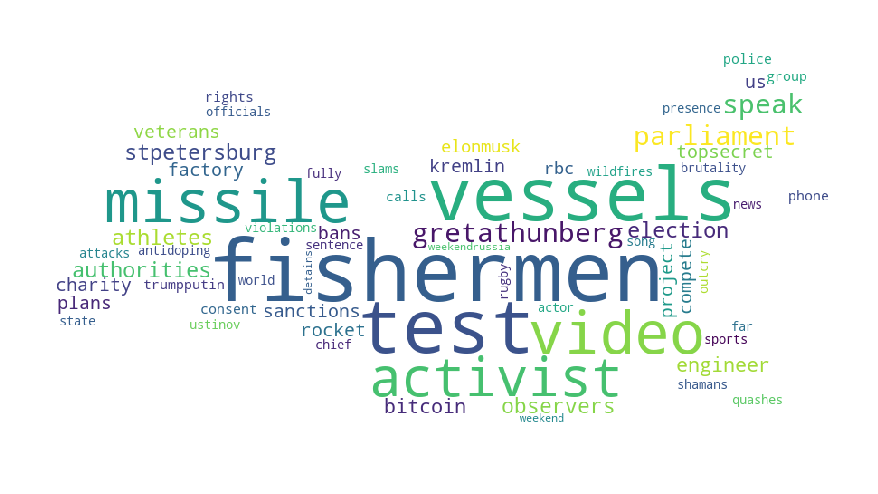

In [20]:
'''Visualizamos en formato nube de palabras: (+info en 
https://blog.goodaudience.com/how-to-generate-a-word-cloud-of-any-shape-in-python-7bce27a55f6e)'''

def generate_wordcloud(text, mask_):
    word_cloud = WordCloud(width = 1000, height = 1000, background_color = "white",
                           mask = mask_).generate(text)
    plt.figure(figsize = (12, 12),facecolor = None)
    plt.imshow(word_cloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

mask = np.array(Image.open(requests.get("https://n9.cl/2s8p", stream = True).raw))
text = ",".join(final_words)

generate_wordcloud(text, mask)